In [57]:
TRAIN_PATH = 'train_amex/train.csv'

In [86]:
import pandas as pd
import numpy as np
import tensorflow as tf
dataset =  pd.read_csv(TRAIN_PATH)
print(dataset.columns)

Index(['session_id', 'DateTime', 'user_id', 'product', 'campaign_id',
       'webpage_id', 'product_category_1', 'product_category_2',
       'user_group_id', 'gender', 'age_level', 'user_depth',
       'city_development_index', 'var_1', 'is_click'],
      dtype='object')


In [87]:
val_frame = dataset[['DateTime','product','webpage_id','product_category_1','campaign_id','user_group_id','gender','age_level','user_depth','city_development_index','var_1','is_click']]

In [88]:
print(val_frame.head)

print(val_frame['product'].unique())
val_temp = val_frame

<bound method NDFrame.head of                 DateTime product  webpage_id  product_category_1  campaign_id  \
0       2017-07-02 00:00       C       13787                   4       359520   
1       2017-07-02 00:00       C       11085                   5       105960   
2       2017-07-02 00:00       C       13787                   4       359520   
3       2017-07-02 00:00       I       13787                   3       359520   
4       2017-07-02 00:01       C       60305                   3       405490   
5       2017-07-02 00:01       I       13787                   2       359520   
6       2017-07-02 00:01       F       60305                   3       405490   
7       2017-07-02 00:01       C       13787                   3       360936   
8       2017-07-02 00:02       H       11085                   5       105960   
9       2017-07-02 00:02       B       13787                   2       360936   
10      2017-07-02 00:02       C       60305                   3       405490  

In [89]:
val_temp['DateTime'] = val_temp['DateTime'].apply(lambda x: (x[11:13]))


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [90]:
val_temp['DateTime'] = pd.to_numeric(val_temp['DateTime'])

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [91]:
X = val_temp.copy()

In [92]:
X.head()

,DateTime,product,webpage_id,product_category_1,campaign_id,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,0,C,13787,4,359520,10.0,Female,4.0,3.0,3.0,0,0
1,0,C,11085,5,105960,8.0,Female,2.0,2.0,NaN,0,0
2,0,C,13787,4,359520,8.0,Female,2.0,2.0,NaN,0,0
3,0,I,13787,3,359520,3.0,Male,3.0,3.0,2.0,1,0
4,0,C,60305,3,405490,2.0,Male,2.0,3.0,2.0,1,0


In [93]:
#Dealing with nan values.
print(X['age_level'].isna().sum())

positive_samples = val_temp[val_temp.is_click == 1]
negative_samples = val_temp[val_temp.is_click == 0]

print(negative_samples['city_development_index'].isna().sum()/len(negative_samples))
print(positive_samples['city_development_index'].isna().sum()/len(positive_samples))
# X['user_group_id'].unique()


X = X.dropna(subset=['user_group_id','user_depth','city_development_index','gender','age_level'])
len(X)

18243
0.27004120751921473
0.2707222878299448


338162

In [94]:
# X.age_level = val_temp.age_level.apply(str)
X['age_level'] = pd.to_numeric(X['age_level'])
X['user_depth'] = pd.to_numeric(X['user_depth'])
X['city_development_index'] = pd.to_numeric(X['city_development_index'])
X.product_category_1 = val_temp.product_category_1.apply(str)
X.user_group_id = val_temp.user_group_id.apply(str)
X.webpage_id = val_temp.webpage_id.apply(str)
X.var_1 = val_temp.var_1.apply(str)
X.campaign_id = val_temp.campaign_id.apply(str)
X.head()

,DateTime,product,webpage_id,product_category_1,campaign_id,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,0,C,13787,4,359520,10.0,Female,4.0,3.0,3.0,0,0
3,0,I,13787,3,359520,3.0,Male,3.0,3.0,2.0,1,0
4,0,C,60305,3,405490,2.0,Male,2.0,3.0,2.0,1,0
6,0,F,60305,3,405490,9.0,Female,3.0,3.0,4.0,0,0
7,0,C,13787,3,360936,4.0,Male,4.0,3.0,4.0,0,0


In [671]:
X['campaign_id'].unique()

array([2, 6, 3, 5, 0, 9, 8, 7, 4, 1])

In [96]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [97]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# labelencoder_X = LabelEncoder()
# X[:,1] = labelencoder_X.fit_transform(X[:, 1])
# X[:,2] = labelencoder_X.fit_transform(X[:, 2])
# X[:,3] = labelencoder_X.fit_transform(X[:, 3])
# X[:,4] = labelencoder_X.fit_transform(X[:, 4])
# X[:,5] = labelencoder_X.fit_transform(X[:, 5])
# X[:,6] = labelencoder_X.fit_transform(X[:, 6])
# X[:,10] = labelencoder_X.fit_transform(X[:, 10])
# onehotencoder = OneHotEncoder()

X = MultiColumnLabelEncoder(columns = ['product']).fit_transform(X)
X = MultiColumnLabelEncoder(columns = ['webpage_id']).fit_transform(X)
X = MultiColumnLabelEncoder(columns = ['product_category_1']).fit_transform(X)
X = MultiColumnLabelEncoder(columns = ['campaign_id']).fit_transform(X)
X = MultiColumnLabelEncoder(columns = ['user_group_id']).fit_transform(X)
X = MultiColumnLabelEncoder(columns = ['gender']).fit_transform(X)
X = MultiColumnLabelEncoder(columns = ['webpage_id']).fit_transform(X)
# Xtest = onehotencoder.fit_transform(Xtest).toarray()
X.head()

,DateTime,product,webpage_id,product_category_1,campaign_id,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,0,2,1,3,2,2,0,4.0,3.0,3.0,0,0
3,0,8,1,2,2,6,1,3.0,3.0,2.0,1,0
4,0,2,7,2,6,5,1,2.0,3.0,2.0,1,0
6,0,5,7,2,6,12,0,3.0,3.0,4.0,0,0
7,0,2,1,2,3,7,1,4.0,3.0,4.0,0,0


In [691]:
test = X.copy()


In [692]:

ohe = OneHotEncoder(categorical_features=[1,2,3,4,5,6,10])

test = ohe.fit_transform(test).toarray()


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [693]:
test = np.delete(test,[0,10,19,24,34,47,49],axis=1)

In [694]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [695]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

In [696]:
ex = test[:,:-1]
why = test[:,-1]

In [697]:
# np.count_nonzero(why)
forest.fit(ex,why)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [698]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

In [699]:
indices = np.argsort(importances)[::-1]

In [700]:
# Print the feature ranking
print("Feature ranking:")

for f in range(ex.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 44 (0.684847)
2. feature 47 (0.146991)
3. feature 46 (0.028135)
4. feature 43 (0.023096)
5. feature 45 (0.009405)
6. feature 6 (0.007071)
7. feature 7 (0.005582)
8. feature 1 (0.005116)
9. feature 2 (0.004398)
10. feature 18 (0.004323)
11. feature 26 (0.004221)
12. feature 35 (0.004007)
13. feature 36 (0.003799)
14. feature 15 (0.003797)
15. feature 34 (0.003711)
16. feature 17 (0.003609)
17. feature 42 (0.003570)
18. feature 0 (0.003438)
19. feature 37 (0.003042)
20. feature 9 (0.003032)
21. feature 41 (0.002971)
22. feature 30 (0.002798)
23. feature 5 (0.002735)
24. feature 19 (0.002709)
25. feature 32 (0.002642)
26. feature 23 (0.002456)
27. feature 4 (0.002443)
28. feature 31 (0.002421)
29. feature 20 (0.002407)
30. feature 3 (0.002354)
31. feature 40 (0.002120)
32. feature 38 (0.001743)
33. feature 8 (0.001578)
34. feature 33 (0.001499)
35. feature 22 (0.001380)
36. feature 12 (0.001283)
37. feature 39 (0.001184)
38. feature 27 (0.001151)
39. feature 29

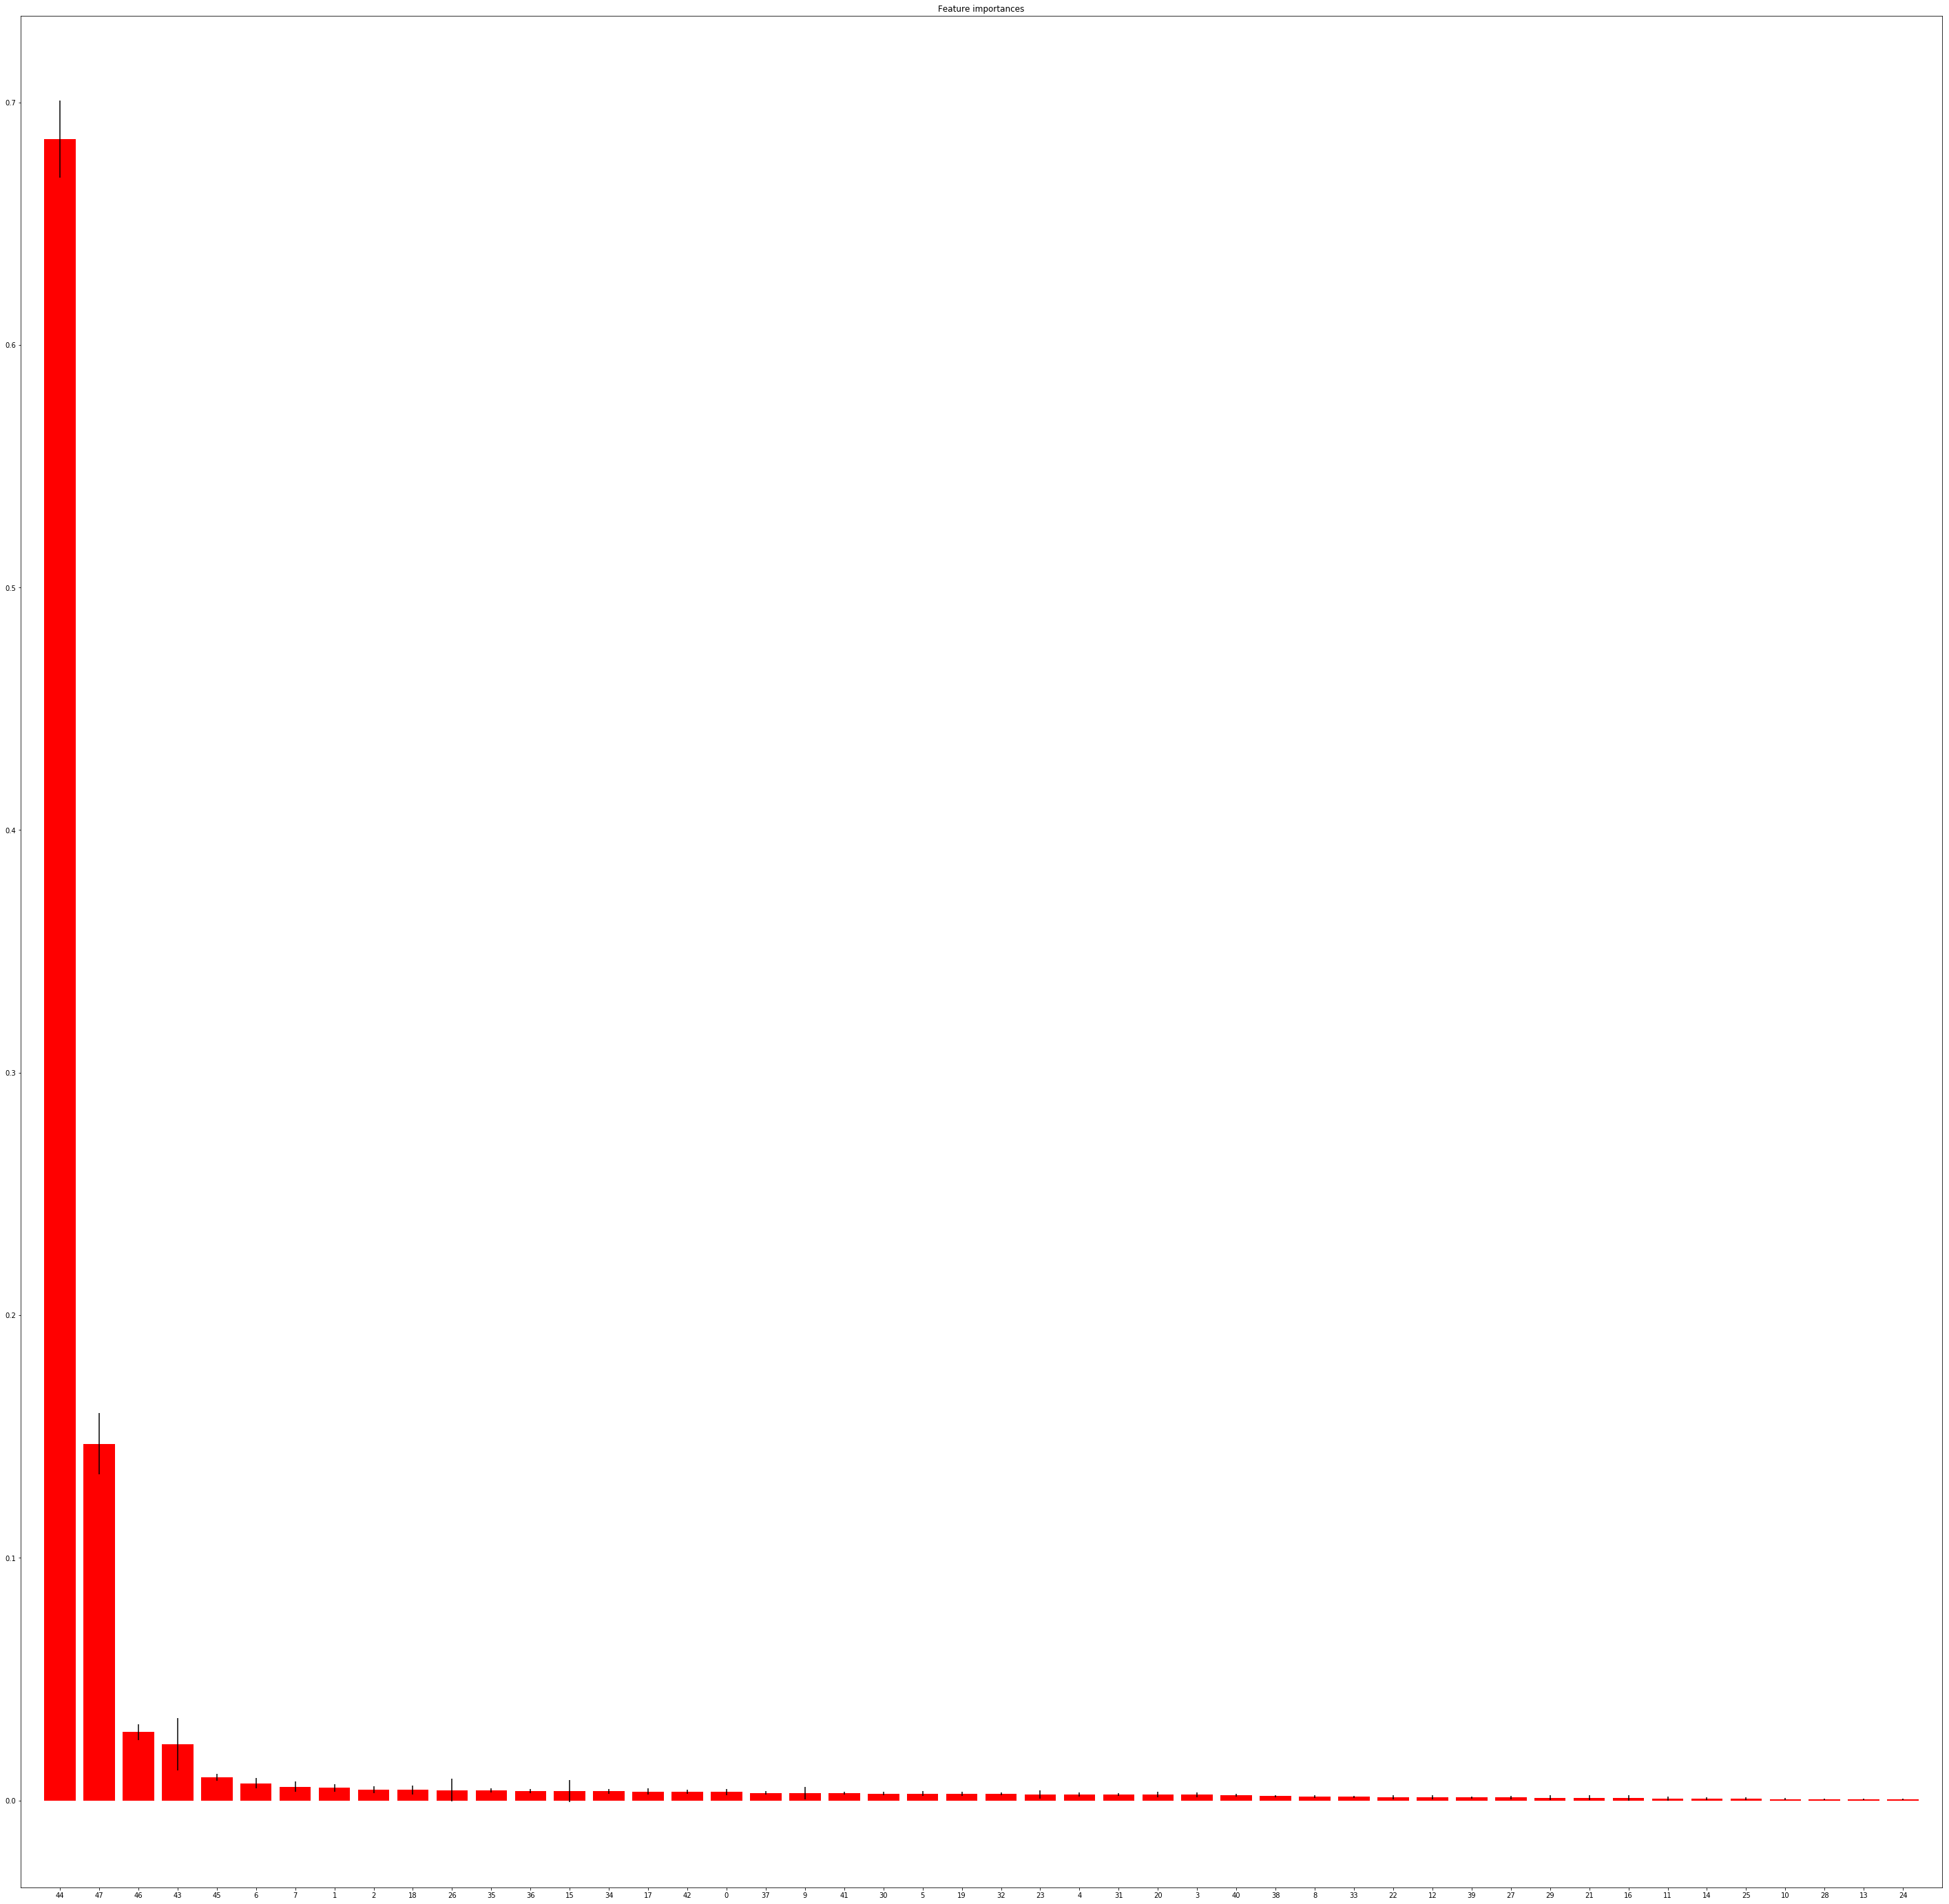

In [701]:
# Plot the feature importances of the forest
plt.figure(figsize=(50,50))
plt.title("Feature importances")
plt.bar(range(ex.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(ex.shape[1]), indices)
plt.xlim([-1, ex.shape[1]])
plt.show()

ex = ex[:,[44,47,46,43,45,6,7,1,2,18]]
ex

In [726]:
ex = test[:,:-1]
why = test[:,-1]
ex = ex[:,[44,47,46,43,45]]

In [727]:
test[:,1]

array([1., 0., 1., ..., 0., 0., 1.])

In [728]:
from sklearn.ensemble import RandomForestClassifier

In [729]:
from sklearn.model_selection import train_test_split

In [730]:
X_train,X_test,Y_train,Y_test = train_test_split(ex,why,test_size=0.2,random_state=101)

In [767]:
w = 1

In [768]:
rf = RandomForestClassifier(class_weight={0:1,1:w})

In [769]:
rf.fit(ex,why)

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [773]:
xt = pd.read_csv('test.csv')
val_frame_test = xt[['DateTime','product','webpage_id','product_category_1','campaign_id','user_group_id','gender','age_level','user_depth','city_development_index','var_1']]
val_frame_test['DateTime'] = val_temp['DateTime'].apply(lambda x: str(x[11:13]))
val_frame_test = val_frame_test.dropna(subset=['user_group_id','user_depth','city_development_index','gender','age_level'])

TypeError: 'int' object is not subscriptable

In [764]:
from sklearn.metrics import roc_auc_score

In [765]:
y_pred = rf.predict(X_test) 

In [766]:
print(roc_auc_score(y_pred,Y_test))
y_pred

0.5456623476511655


array([0., 0., 0., ..., 0., 0., 0.])